In [1]:
%matplotlib inline
import random
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

# =========
# Get rid of warnings
# =========
import os
import logging
class WarningFilter(logging.Filter):
    def filter(self, record):
        msg = record.getMessage()
        tf_warning = '(from tensorflow.contrib.learn.python.learn.' in msg
        return not tf_warning

logger = logging.getLogger('tensorflow')
logger.addFilter(WarningFilter())
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = 28


class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-3, batch_size=100, n_z=10):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 512, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 384, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 256, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 256, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 384, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 512, scope='dec_fc3', activation_fn=tf.nn.elu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat),
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat

    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

def trainer(learning_rate=1e-3, batch_size=100, num_epoch=75, n_z=10):
    model = VariantionalAutoencoder(learning_rate=learning_rate,
                                    batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        for iter in range(num_sample // batch_size):
            # Obtina a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and the backward pass and report computed losses
            loss, recon_loss, latent_loss = model.run_single_step(batch[0])

        if epoch % 5 == 0:
            print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(
                epoch, loss, recon_loss, latent_loss))

    print('Done!')
    return model


model = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=75, n_z=5)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')
test_image = mnist.test.images
test_label = mnist.test.labels
def generateTenRandomPairs(images,labels):
    resultArr = [];
    for i in range(0,10):
        randomPair = random.randint(0,9)
        sameDigitArr = np.where(labels == randomPair)[0]
        numberOneIdx = random.randint(0,len(sameDigitArr)-1)
        numberOneImg = sameDigitArr[numberOneIdx]
        numberTwoIdx = random.randint(0,len(sameDigitArr)-1)
        numberTwoImg = sameDigitArr[numberTwoIdx]

        code1 = model.transformer(images[numberOneImg].reshape(1,784))
        code2 = model.transformer(images[numberTwoImg].reshape(1,784))

        diff = (code2 - code1) / 8

        result = np.zeros((9, 28, 28))
        result[0] = images[numberOneImg].reshape(28, 28)
        result[-1] = images[numberTwoImg].reshape(28, 28)
        for j in range(1, 8):
            img = code1 + j * diff
            result[j] = model.generator(img).reshape(28, 28)
        resultArr.append(result)
    return resultArr;


def generateTenDiffPairs(images,labels):
    resultArr = [];
    for i in range(0,10):
        randomOne = random.randint(0,9)
        sameDigitArr = np.where(labels == randomOne)[0]
        numberOneIdx = random.randint(0,len(sameDigitArr)-1)
        numberOneImg = sameDigitArr[numberOneIdx]
        
        randomTwo = random.randint(0,9)
        while randomTwo == randomOne:
            randomTwo = random.randint(0,9)
        sameDigitArr = np.where(labels == randomTwo)[0]
        numberTwoIdx = random.randint(0,len(sameDigitArr)-1)
        numberTwoImg = sameDigitArr[numberTwoIdx]
        

        code1 = model.transformer(images[numberOneImg].reshape(1,784))
        code2 = model.transformer(images[numberTwoImg].reshape(1,784))

        diff = (code2 - code1) / 8

        result = np.zeros((9, 28, 28))
        result[0] = images[numberOneImg].reshape(28, 28)
        result[-1] = images[numberTwoImg].reshape(28, 28)
        for j in range(1, 8):
            img = code1 + j * diff
            result[j] = model.generator(img).reshape(28, 28)
        resultArr.append(result)
    return resultArr;
    
    
pairRandArr = generateTenRandomPairs(test_image,test_label)
pairDiffArr = generateTenDiffPairs(test_image,test_label)

print('DDDD')



    
# for i in range(len(pairRandArr)):
# #     big_img = 
#     for img in pairRandArr[i]:
        
#         plt.figure(figsize=(1,1))
#         plt.axis('off')
#         plt.imshow(img, cmap='gray')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
[Epoch 0] Loss: 169.53761291503906, Recon loss: 159.96385192871094, Latent loss: 9.573763847351074
[Epoch 5] Loss: 134.8551025390625, Recon loss: 124.06167602539062, Latent loss: 10.79343032836914
[Epoch 10] Loss: 131.3899383544922, Recon loss: 120.63861083984375, Latent loss: 10.751317024230957
[Epoch 15] Loss: 123.69649505615234, Recon loss: 112.77964782714844, Latent loss: 10.916849136352539
[Epoch 20] Loss: 116.50575256347656, Recon loss: 105.45630645751953, Latent loss: 11.049439430236816
[Epoch 25] Loss: 119.31688690185547, Recon loss: 108.13877868652344, Latent loss: 11.178096771240234
[Epoch 30] Loss: 125.91214752197266, Recon loss: 114.29798126220703, Latent loss: 11.614165306091309
[Epoch 35] Loss: 122.72636413574219, Recon loss: 110.71672821044922, Latent loss: 12.009634017944336
[Epo

In [2]:
# for idx in range(len(pairDiffArr[0])):
plt.close('all')
# totalimg = [];
# rowimg = [];

# for idx in range(len(pairDiffArr)):
#     for i in range(len(pairDiffArr[0])):
#         rowimg = np.concatenate((rowimg, pairDiffArr[idx][i]), axis=0)
#     totalimg = np.concatenate((totalimg, rowimg), axis=1)

line = pairDiffArr[0]
row_img = line[0]
for i in range(1, line.shape[0]):
    row_img = np.concatenate((row_img, line[i]), axis=1)
totalimg = row_img;

for i in range(1,len(pairDiffArr)):
    line = pairDiffArr[i]
    big_img = line[0]
    for i in range(1, line.shape[0]):
        big_img = np.concatenate((big_img, line[i]), axis=1)
    totalimg = np.concatenate((totalimg, big_img), axis=0)

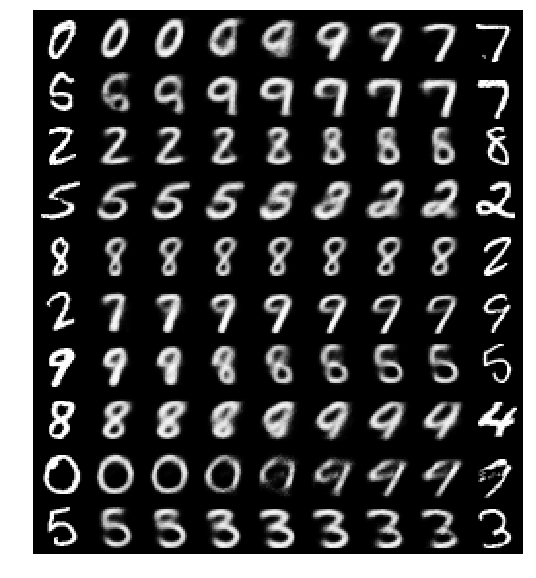

In [3]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(totalimg, cmap='gray')
plt.show()